## Solving the Bergers Equation using SPINN

Reference: https://www.sciencedirect.com/science/article/abs/pii/S0021999121004952

Burger's PDE $ u_t + uu_x - (0.01/\pi) u_{xx} = 0 $<br>
Valid in Domain: $ x \in [-1,1] $ and $ t \in (0,1] $<br>
Initial Condition: $ u(0,x) = - \sin(\pi x) $<br>
Boundary Condition: $ u(t,-1) = u(t,1) = 0 $<br>

In [ ]:
import tensorflow as tf
import math as m

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float
pi = tf.constant(m.pi, dtype=DTYPE)

def u_init(x): # calculates u value at initial data points
  return -tf.sin(pi * x)

def u_bound(t, x): # calculates u value at boundary data points
  n = x.shape[0]
  return tf.zeros((n,1), dtype=DTYPE)

def f_val(u, u_t, u_x, u_xx): # calculates f value given u and its derivatives
  return u_t + u * u_x - (0.01/pi) * u_xx

In [ ]:
Ni, Nb, Nc = 50, 50, 10000 # no of initial, boundary and collocation points

tmin, tmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on time
xmin, xmax = -tf.constant(1.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

ti = tf.ones((Ni,1))*tmin # tmin repeated Ni times
xi = tf.random.uniform((Ni,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init = tf.concat([ti, xi], axis=1) # Initial Data Points
ui = u_init(xi) # Evaluate Initial Condition

tb = tf.random.uniform((Nb,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
bin = tf.keras.backend.random_bernoulli((Nb,1), 0.5, dtype=DTYPE) # randomly generate 0 or 1 Nb times
xb = xmin + (xmax - xmin) * bin # convert 0s and 1s to xmin and xmax
bound = tf.concat([tb, xb], axis=1) # Boundary Data Points
ub = u_bound(tb, xb) # Evaluate Boundary Condition

tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll = tf.concat([tc, xc], axis=1) # Collocation Data Points

In [ ]:
def kernel(n_hidden = 3, n_neurons = 3):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(1)) # Input Layer
  for i in range(n_hidden): # n_hidden layers each with n_neurons and swish activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_normal'))
  model.add(tf.keras.layers.Dense(1)) # Output Layer
  return model

In [ ]:
import keras

class Layer1(keras.layers.Layer):
    def __init__(self, units=100, input_dim=2):
        super().__init__()
        self.b = self.add_weight(shape=(input_dim, units), initializer="zeros", trainable=True)
        self.w = self.add_weight(shape=(units,), initializer="glorot_normal", trainable=True)
        self.u = units
    def call(self, inputs):
        z1 = tf.math.multiply((tf.tile(inputs[:, :, tf.newaxis], [1, 1, self.u]))-self.b,1/self.w)
        z2 = tf.math.square(z1)
        z3 = tf.math.reduce_sum(z2,axis=1)
        z4 = tf.math.sqrt(z3)
        return z4

class Layer2(keras.layers.Layer):
    def __init__(self, units=100, output_dim=1):
        super().__init__()
        self.u = self.add_weight(shape=(units, output_dim), initializer="glorot_normal", trainable=True)
    def call(self, inputs):
        z = tf.math.exp(-0.5*(tf.math.square(inputs)))
        return tf.matmul(z, self.u)

In [ ]:
def u_model(n_neurons = 400):
  inputs = tf.keras.Input(2) # Input Layer for x and t
  layer_1 = Layer1(n_neurons,2)
  hidden = layer_1(inputs) # Mesh Encoding Layer
  layer_2 = Layer2(n_neurons,1)
  outputs = layer_2(hidden) # Kernel Layer to yield output u
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

In [ ]:
def get_f(model, cps): # calculate f given model and collocation data points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = model(tf.concat([t, x], axis=1)) # u as a function of t and x
    u_x = tape.gradient(u, x) # defined within context to compute 2nd derivative
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)
  del tape
  return f_val(u, u_t, u_x, u_xx)

In [ ]:
def loss_fxn(model, init, ui, bound, ub, coll): # compute Loss given model and data
  pui = model(init) # Model prediction on initial data
  Li = tf.reduce_mean(tf.square(ui - pui)) # MSE for initial data
  pub = model(bound) # Model prediction on boundary data
  Lb = tf.reduce_mean(tf.square(ub - pub)) # MSE for boundary data
  f = get_f(model, coll) # calculate f given model and collocation data
  Lc = tf.reduce_mean(tf.square(f)) # MSE for collocation data (true value of f is always 0)
  loss = Li + Lb + Lc
  return loss

In [ ]:
def L_and_grad_Lw(model, init, ui, bound, ub, coll): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(model.trainable_variables) # keep track of operations on model training parameters
    loss = loss_fxn(model, init, ui, bound, ub, coll) # loss as a function of model (& hence weights)
  g = tape.gradient(loss, model.trainable_variables)
  del tape
  return loss, g

In [ ]:
model = u_model() # initialise the NN model
#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.Adam(learning_rate=0.01) # Adam optimizer

In [ ]:
@tf.function
def train_step():
  # compute loss and its gradient wrt model parameters
  loss, gradw = L_and_grad_Lw(model, init, ui, bound, ub, coll)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gradw, model.trainable_variables))
  return loss

In [ ]:
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  loss = train_step()
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0))

Final Loss = 0.090644196
Computation Time = 3946.1749160289764 seconds


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = [i for i in range(1,len(losses)+1)]
plt.yscale('log')
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
N = 500
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = model(input)
U = u_pred.numpy().reshape(N+1,N+1)

Text(0.5, 0.92, 'BE Solution by PINN')

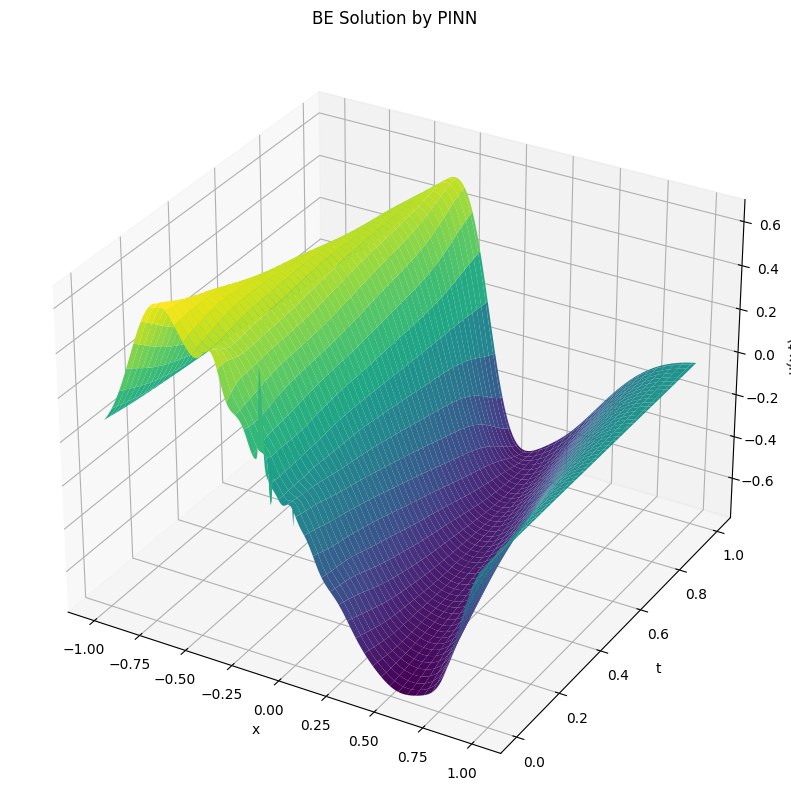

In [ ]:
# Gaussian Kernel
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, U, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('BE Solution by PINN')